# Goal

Test whether the brain has more gene localization than liver or kidney (or vice versa)

Do not have the same genes or cell-types in all datasets, instead compare the distributions of gene/cell-type scores

Perform this test on all spatial metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#Read all gene/ont scores for all metrics into a single large table
biccn_gene_ont_paths = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/*.csv')
vz_brainmap_gene_ont_paths = glob.glob('../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/*.csv')
vz_liver_gene_ont_paths = glob.glob('../../nf_pipeline/outputs/vz_Liver_20220601_direct/gene_ont/*.csv')
czb_seqfish_gene_ont_paths = glob.glob('../../nf_pipeline/outputs/CZB_seqfish_20220728_direct/gene_ont/*.csv')

gene_ont_paths = set().union(
    biccn_gene_ont_paths,
    vz_brainmap_gene_ont_paths,
    vz_liver_gene_ont_paths,
    czb_seqfish_gene_ont_paths,
)

df = pd.concat(pd.read_csv(p) for p in gene_ont_paths)
df['significant'] = df['bh_p'].le(0.05)

#Add a "source" column so "vz_Brainmap_slice1" and "vz_Brainmap_slice2" both get "vz_Brainmap" for example
#(used to average over replicates within each experiment)
experiment_to_source = {
    'BICCN_mouse1':'BICCN',
    'BICCN_mouse2':'BICCN',
    'CZB_kidney':'CZB_kidney',
    'CZB_liver':'CZB_liver',
    'seqfish':'seqfish',
    'vz_Brainmap_slice1':'vz_Brainmap',
    'vz_Brainmap_slice2':'vz_Brainmap',
    'vz_Brainmap_slice3':'vz_Brainmap',
    'vz_Liver_mouse1':'vz_Liver',
    'vz_Liver_mouse2':'vz_Liver',
}

df['source'] = df['experiment'].map(experiment_to_source)

#Add a "tissue" column based on the source
#(used to average over tissues)
source_to_tissue = {
    'BICCN':'Brain',
    'CZB_kidney':'Kidney',
    'CZB_liver':'Liver',
    'seqfish':'Brain',
    'vz_Brainmap':'Brain',
    'vz_Liver':'Liver',
}

df['tissue'] = df['source'].map(source_to_tissue)

df.head()

,experiment,sample,metric,gene,annotation,num_cells,med_gene_spots,med_spots,med_score,z,p,bh_p,significant,source,tissue
0,BICCN_mouse2,m2s1,periph,1700022I11Rik,L23_IT,658,1.0,686.5,-0.239063,-6.341829,2.270535e-10,9.841905e-10,True,BICCN,Brain
1,BICCN_mouse2,m2s1,periph,1700022I11Rik,L56_NP,34,1.0,565.0,-0.328482,-2.575589,1.000695e-02,1.882061e-02,True,BICCN,Brain
2,BICCN_mouse2,m2s1,periph,1700022I11Rik,L5_ET,158,1.0,1040.5,-0.112264,-1.810480,7.022141e-02,1.092954e-01,False,BICCN,Brain
3,BICCN_mouse2,m2s1,periph,1700022I11Rik,L5_IT,310,1.0,792.5,-0.256291,-5.438598,5.370161e-08,1.911233e-07,True,BICCN,Brain
4,BICCN_mouse2,m2s1,periph,1700022I11Rik,L6_CT,279,1.0,479.0,-0.256055,-5.503652,3.720027e-08,1.339866e-07,True,BICCN,Brain


In [3]:
df.groupby('experiment')['metric'].unique().apply(sorted)

experiment
BICCN_mouse1          [central, periph, puncta, radial]
BICCN_mouse2          [central, periph, puncta, radial]
CZB_kidney            [central, periph, puncta, radial]
CZB_liver             [central, periph, puncta, radial]
seqfish               [central, periph, puncta, radial]
vz_Brainmap_slice1    [central, periph, puncta, radial]
vz_Brainmap_slice2    [central, periph, puncta, radial]
vz_Brainmap_slice3    [central, periph, puncta, radial]
vz_Liver_mouse1       [central, periph, puncta, radial]
vz_Liver_mouse2       [central, periph, puncta, radial]
Name: metric, dtype: object

In [4]:
#summary stats of the table
df.describe()

,num_cells,med_gene_spots,med_spots,med_score,z,p,bh_p
count,336753.000000,336753.000000,336753.000000,336753.000000,336753.000000,336753.000000,336753.000000
mean,1303.582852,3.295977,1587.901097,0.047008,1.083921,0.253234,0.355126
std,3681.721604,7.828689,1804.976436,0.202422,9.739458,0.309319,0.373201
min,20.000000,1.000000,62.500000,-0.871559,-298.214985,0.000000,0.000000
25%,41.000000,1.000000,540.000000,-0.064310,-0.935386,0.000019,0.000064
50%,146.000000,2.000000,991.500000,0.032425,0.553030,0.087298,0.197506
75%,688.000000,3.000000,1277.000000,0.146000,2.552016,0.472278,0.733140
max,49728.000000,358.000000,10874.500000,0.999000,271.869389,1.000000,1.000000


In [5]:
#Count how many genes are found to be significant in ANY cell-type for each sample
(
    df.groupby(
        ['source','metric','gene']
    )['significant']
    .any()
    .reset_index()
    .pivot_table(
        index=['source','metric'],
        columns='significant',
        aggfunc = 'count',
        fill_value = 0,
    )
    .reset_index()
)


source   metric  gene     
significant                       False True
0                  BICCN  central     0  252
1                  BICCN   periph     0  252
2                  BICCN   puncta     3  248
3                  BICCN   radial    10  241
4             CZB_kidney  central    33  274
5             CZB_kidney   periph    30  277
6             CZB_kidney   puncta    63  209
7             CZB_kidney   radial    83  189
8              CZB_liver  central    50  255
9              CZB_liver   periph    38  267
10             CZB_liver   puncta    20  142
11             CZB_liver   radial    96   66
12               seqfish  central  9671  134
13               seqfish   periph  9612  193
14               seqfish   puncta  2413   10
15               seqfish   radial  2423    0
16           vz_Brainmap  central    92  497
17           vz_Brainmap   periph    96  493
18           vz_Brainmap   puncta    42  328
19           vz_Brainmap   radial    52  318
20              vz_Liver  central     0  385
21              vz_Liver   periph     0  385
22              vz_Liver   puncta    12  373
23              vz_Liver   radial    46  339

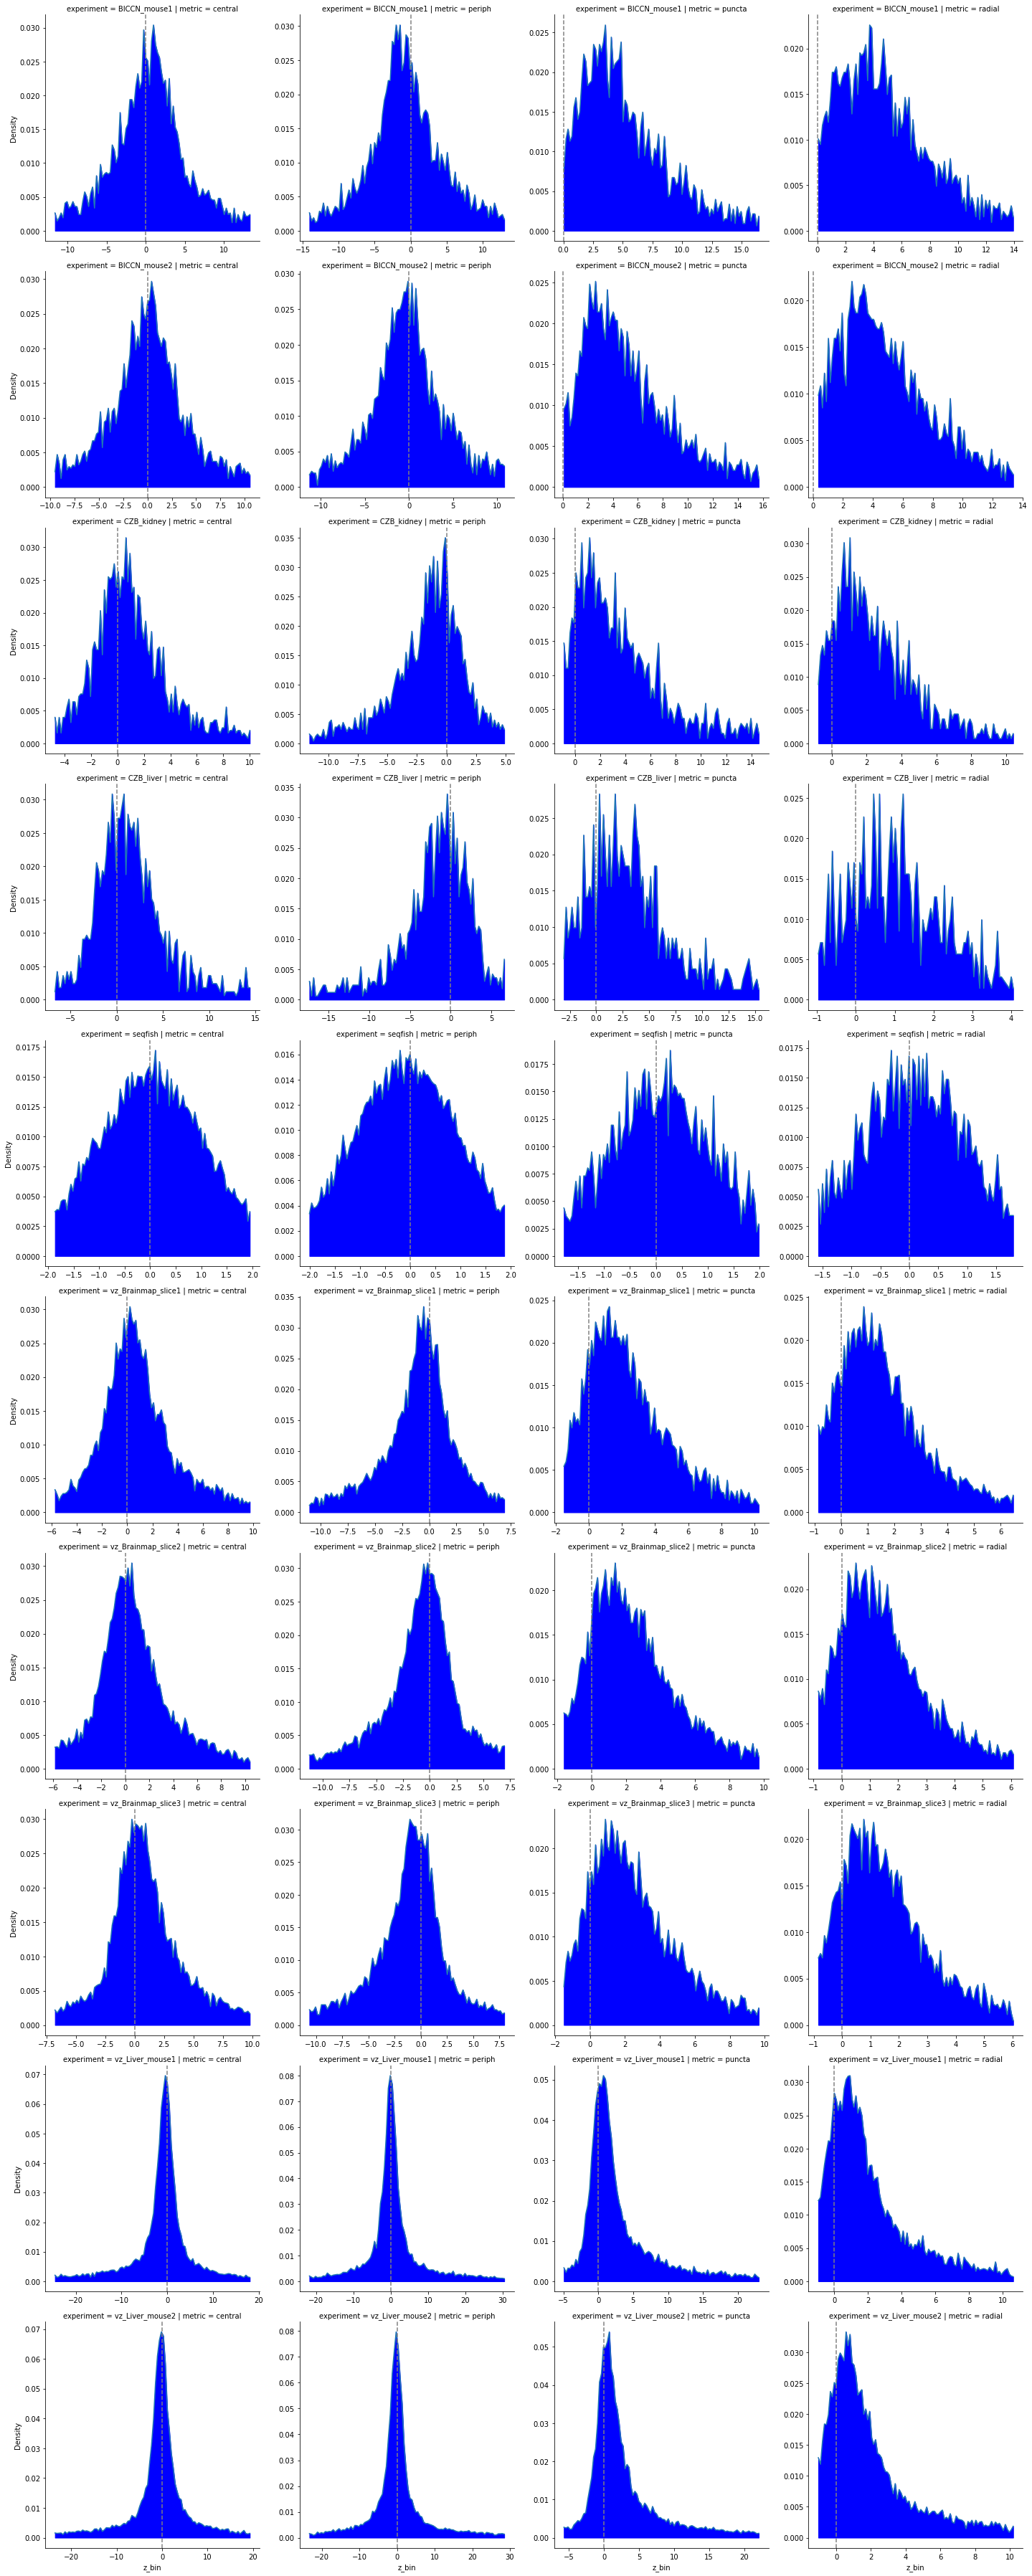

In [6]:
#Plotting z-score distributions as densities per experiment

#Get z by density data in a new table
outlier_quantile_size = 0.05
num_bins = 100

plot_df = pd.DataFrame()
for (experiment,metric),exp_df in df.groupby(['experiment','metric']):
    
    #filter outliers
    exp_df = exp_df[
        exp_df['z'].between(
            exp_df['z'].quantile(outlier_quantile_size),
            exp_df['z'].quantile(1-outlier_quantile_size),
        )
    ]
    
    #histogram densities
    exp_df['z_bin'] = pd.cut(exp_df['z'], bins=num_bins).apply(lambda v: v.left).astype(float)
    hist_df = exp_df.groupby('z_bin')['z'].count().reset_index(name='count')
    hist_df['Density'] = hist_df['count']/hist_df['count'].sum()
    hist_df['experiment'] = experiment
    hist_df['metric'] = metric
    
    plot_df = pd.concat((plot_df,hist_df))
    
g = sns.relplot(
    x = 'z_bin',
    y = 'Density',
    kind = 'line',
    row = 'experiment',
    col = 'metric',
    data = plot_df,
    facet_kws = {'sharex':False, 'sharey':False},
)

for ax in g.axes.flat:
    if len(ax.lines) > 0:
        line = ax.lines[0]
        ax.fill_between(line.get_xdata(), line.get_ydata(), color='blue')
        ax.axvline(0, linestyle='dashed', color='grey')

plt.show()
plt.close()

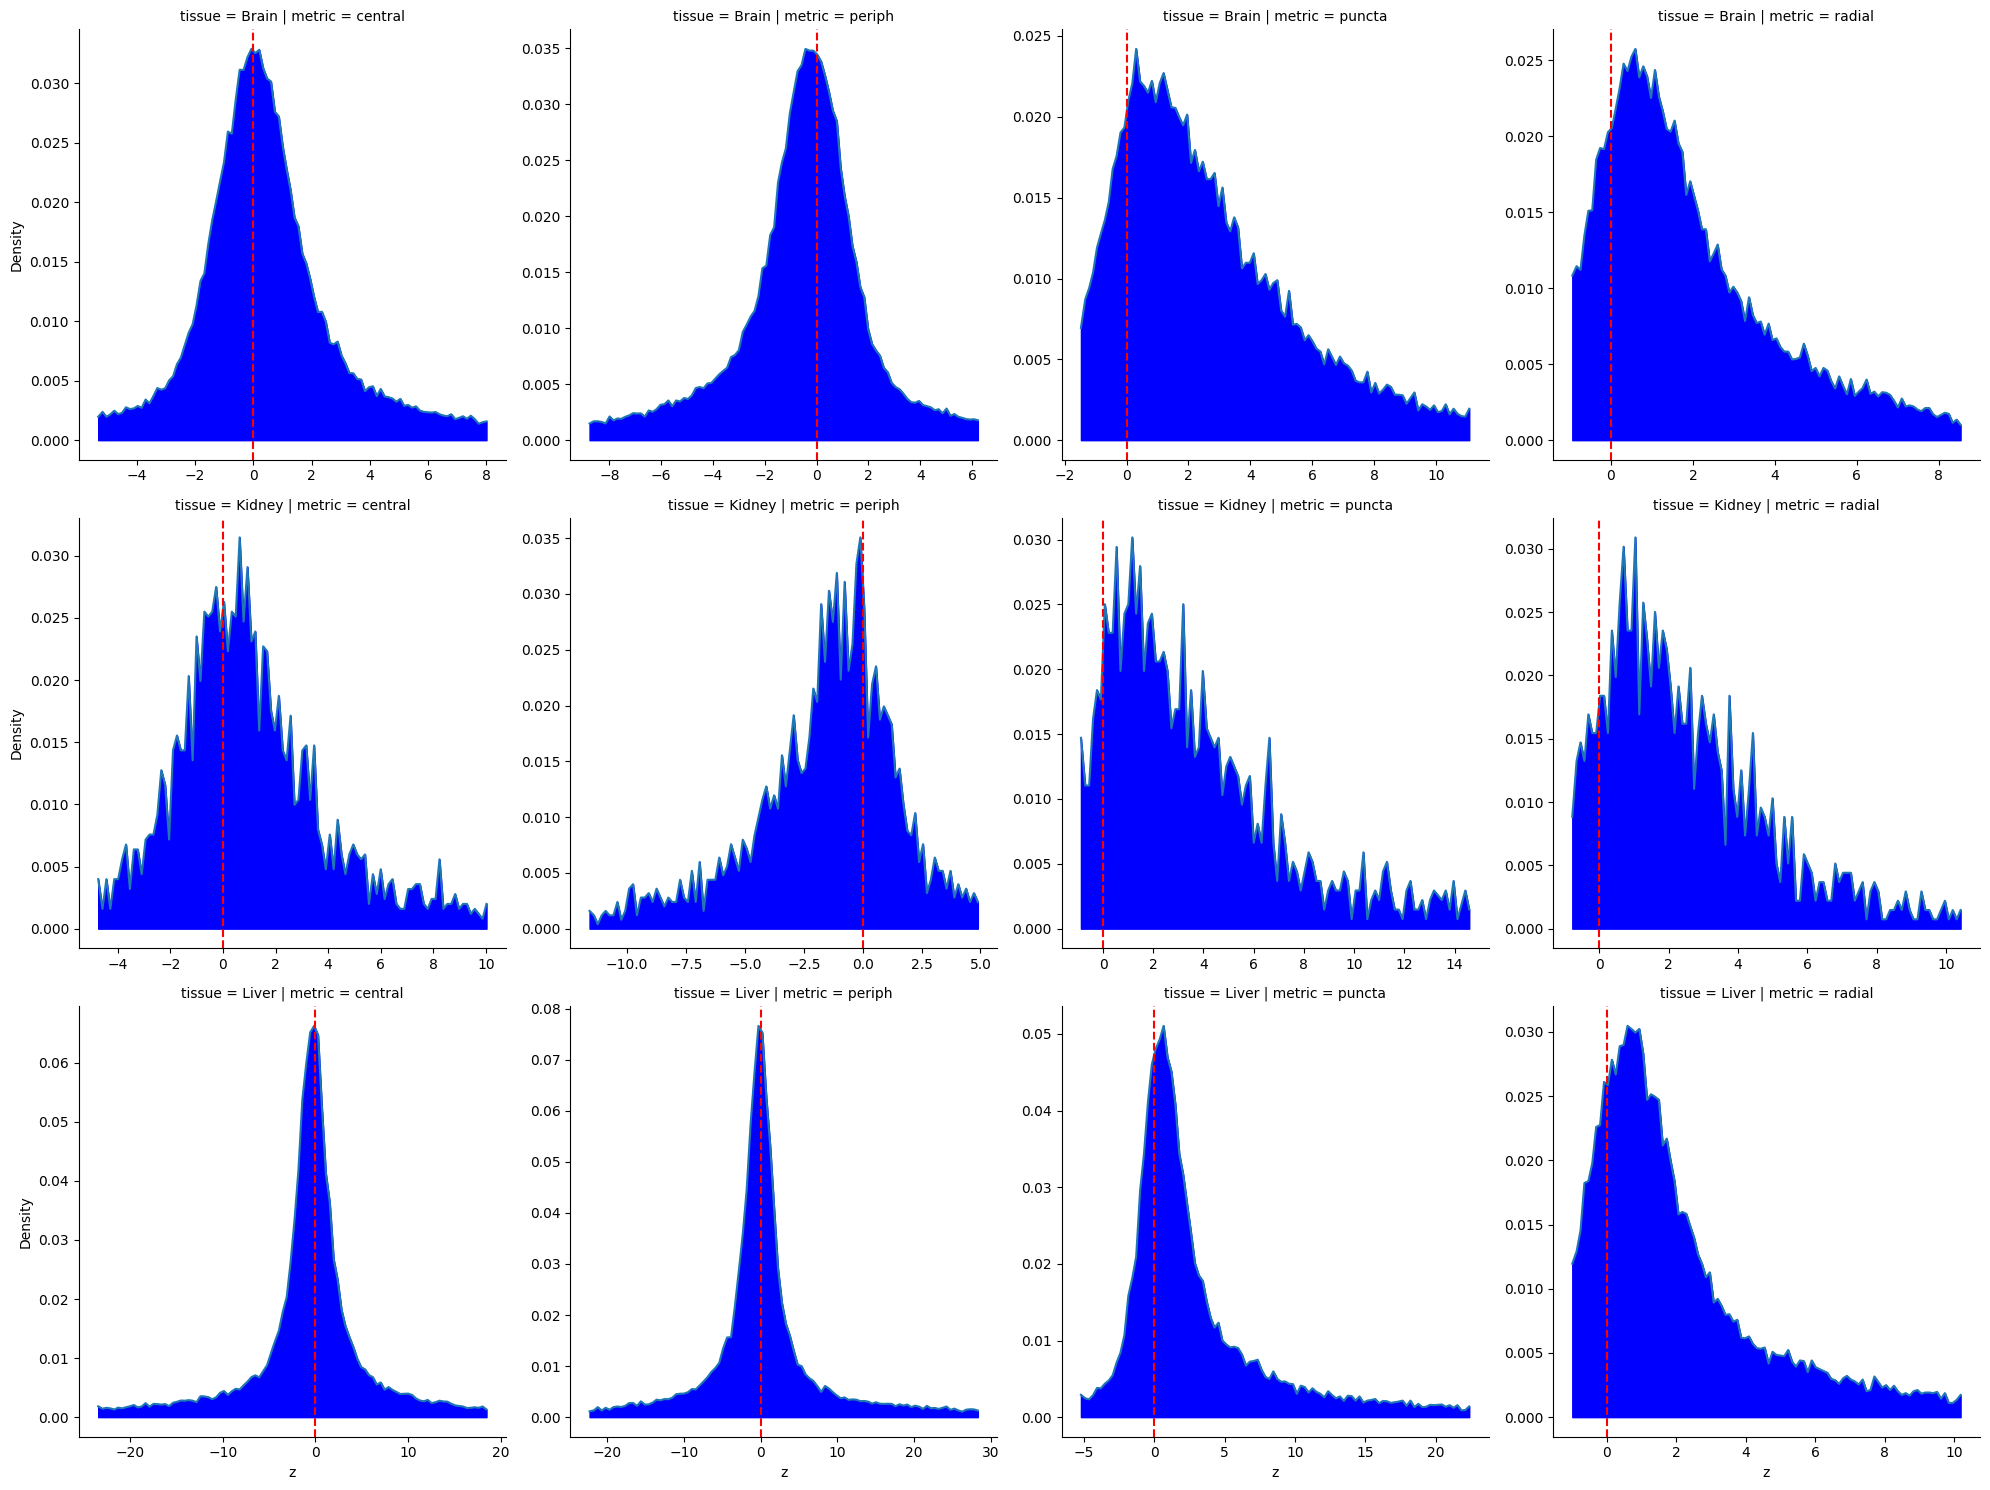

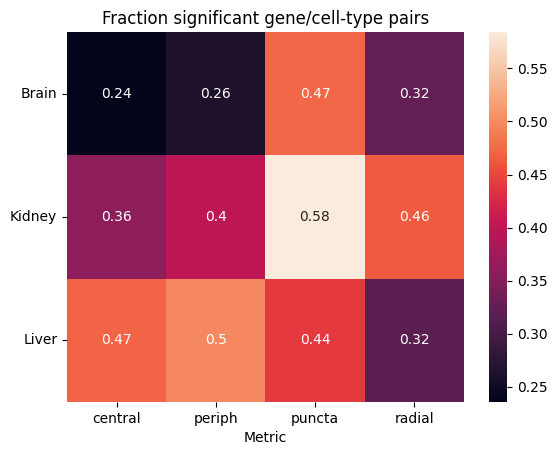

In [11]:
#Plotting z-score distributions as densities per tissue

#Get z by density data in a new table
outlier_quantile_size = 0.05
num_bins = 100

plot_df = pd.DataFrame()
sig_df = pd.DataFrame()
for (tissue,metric),exp_df in df.groupby(['tissue','metric']):
    
    #filter outliers
    exp_df = exp_df[
        exp_df['z'].between(
            exp_df['z'].quantile(outlier_quantile_size),
            exp_df['z'].quantile(1-outlier_quantile_size),
        )
    ]
    
    #histogram densities
    exp_df['z'] = pd.cut(exp_df['z'], bins=num_bins).apply(lambda v: v.left).astype(float)
    hist_df = exp_df.groupby('z')['z'].count().reset_index(name='count')
    hist_df['Density'] = hist_df['count']/hist_df['count'].sum()
    hist_df['tissue'] = tissue
    hist_df['metric'] = metric
    
    #Determine significant/insignificant counts
    exp_sig_df = pd.DataFrame({
        'Tissue':[tissue],
        'Metric':[metric],
        'Num significant':[exp_df['significant'].sum()],
        'Num insignificant':[(~exp_df['significant']).sum()],
        'Frac significant':[exp_df['significant'].sum()/len(exp_df)],
    })
    
    
    plot_df = pd.concat((plot_df,hist_df))
    sig_df = pd.concat((sig_df,exp_sig_df))


#Perform the plotting
g = sns.relplot(
    x = 'z',
    y = 'Density',
    kind = 'line',
    row = 'tissue',
    col = 'metric',
    data = plot_df,
    facet_kws = {'sharex':False, 'sharey':False},
)

for ax in g.axes.flat:
    if len(ax.lines) > 0:
        line = ax.lines[0]
        ax.fill_between(line.get_xdata(), line.get_ydata(), color='blue')
        ax.axvline(0, linestyle='dashed', color='red')

plt.show()
plt.close()

#Make a heatmap of the fraction gene/cell-types that are significant
sns.heatmap(
    annot = True,
    data = sig_df.pivot(index='Tissue',columns='Metric',values='Frac significant')
)
plt.title('Fraction significant gene/cell-type pairs')
plt.yticks(rotation=0)
plt.ylabel('')
plt.show()
plt.close()

In [8]:
sig_df

,Tissue,Metric,Num significant,Num insignificant,Frac significant
0,Brain,central,15338,49706,0.235810
0,Brain,periph,17039,48005,0.261961
0,Brain,puncta,13637,15164,0.473491
0,Brain,radial,9358,19443,0.324919
0,Kidney,central,905,1604,0.360701
0,Kidney,periph,1001,1508,0.398964
0,Kidney,puncta,794,565,0.584253
0,Kidney,radial,630,729,0.463576
0,Liver,central,14861,16728,0.470449
0,Liver,periph,15735,15854,0.498116


In [9]:
df[df['tissue'].eq('Kidney') & df['metric'].eq('radial')]['significant'].value_counts()

False    803
True     708
Name: significant, dtype: int64

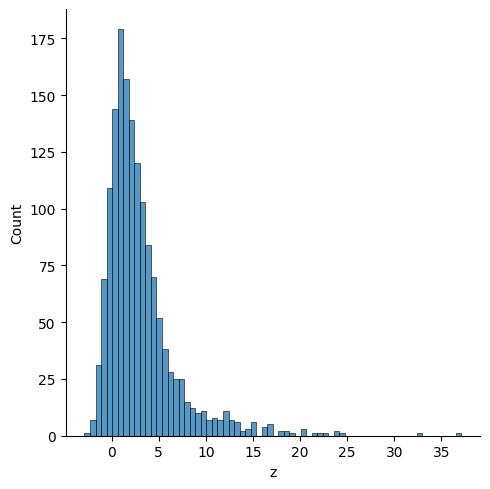

In [10]:
sns.displot(df[df['tissue'].eq('Kidney') & df['metric'].eq('radial')]['z'])
plt.show()
plt.close()